In [85]:
from __future__ import print_function
import sys
import os
import numpy as np
import pandas as pd
from math import asin, acos, sqrt, sin, cos, radians, degrees, asinh
from matplotlib import pyplot as plt
import seaborn as sns
import csv
from mpl_toolkits.basemap import Basemap
from scipy.ndimage import filters
from scipy.ndimage import interpolation
import cv2
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollectioninpu


In [86]:
import shapefile
def readTopologyPlatepolygonFile(filename):
    '''
    Reads shapefiles and returns the all the data fields
    '''
    shapeRead = shapefile.Reader(filename)

    recs    = shapeRead.records()
    shapes  = shapeRead.shapes()
    fields  = shapeRead.fields
    Nshp    = len(shapes)
    
    return(recs,shapes,fields,Nshp)

In [122]:
time1='219'
prediction_file="data_predictions/"+time1+"Ma_/results/deposit_results.csv"
predictions = pd.read_csv(prediction_file, header=None)
subject = "coal"

In [123]:
latitudes     = predictions.loc[:,0]
longitudes    = predictions.loc[:,1]

#xt    = predictions.loc[:,3]
 


# ## SET UP GRIDS
lon_min = -180.
lon_max =  180.
lat_min =  -90.
lat_max =   90.
lon_spacing = 3 #2.51

lon_coords = np.arange(lon_min,lon_max-0.5*lon_spacing,lon_spacing) # left edge of grid
nlonbins = len(lon_coords)
print("Number of Longitudinal bins = %i"%nlonbins)
nlatbins = 2 * int(nlonbins * lat_max / 561.) # rough guess to allow a square bin at equator
print("Number of Latitudinal bins = %i"%nlatbins)
lat_coords = np.empty(nlatbins) # lower edge of grid
lat_spacing = np.empty(nlatbins)
for ilat in np.arange(nlatbins):
    coslat = 1. - 2.*ilat/float(nlatbins)
    lat_rad = acos(coslat)
    lat_coords[ilat] = degrees(lat_rad) - 90.
for ilat in np.arange(nlatbins-1):
    lat_spacing[ilat] = lat_coords[ilat+1] - lat_coords[ilat]
lat_spacing[nlatbins-1] = 90. - lat_coords[nlatbins-1]
print("Check central latitude bin-edges ...")
print(lat_coords[nlatbins/2-1:nlatbins/2+2])
# remove polar grid-bins
nlatbins = nlatbins-2
lat_coords = lat_coords[1:-1]
lat_spacing = lat_spacing[1:-1]

Number of Longitudinal bins = 120
Number of Latitudinal bins = 38
Check central latitude bin-edges ...
[-3.01696131  0.          3.01696131]


In [124]:
map_predict_actual = np.zeros((nlatbins,nlonbins))
map_predict_mean = np.zeros((nlatbins,nlonbins))
map_predict_low  = np.zeros((nlatbins,nlonbins))
map_predict_high = np.zeros((nlatbins,nlonbins))
map_predict_unct = np.zeros((nlatbins,nlonbins))
mask_exclude     = np.zeros((nlatbins,nlonbins))
list_mean = []
list_low  = []
list_high = []
list_unct = []

list_actual = []

if subject == 'coal':
    actual_col =  2
    mean_col  = 5
    high_col =  14
    low_col =  11

if subject == 'glacial':
    actual_col =   7
    mean_col  =  8
    high_col = 16 
    low_col =  13

if subject == 'evaporites':
    actual_col = 6
    mean_col  =  7
    high_col =  15
    low_col =  12


In [125]:
take_pred_mean = True

# pred_wrapper is the wrapper put around predicted values
# i.e. if multiple values, take the mean
pred_wrapper = lambda x: x
if take_pred_mean: 
    pred_wrapper = lambda x: np.mean(x)

for ilon,lon_low in enumerate(lon_coords):
    lon_high = lon_low + lon_spacing
    for ilat,lat_low in enumerate(lat_coords):
        lat_high = lat_low + lat_spacing[ilat]
        this_paleolongitude = (lon_low<=longitudes) & (longitudes<=lon_high)
        this_paleolatitude  = (lat_low<=latitudes) & (latitudes<=lat_high)
        #print(ilon,ilat,here.any())
        here = (this_paleolongitude & this_paleolatitude)
        if(here.any()):
            map_predict_actual[nlatbins-ilat-1,ilon] = pred_wrapper(predictions.loc[here,actual_col].values)
            map_predict_mean[nlatbins-ilat-1,ilon] = pred_wrapper(predictions.loc[here,mean_col].values)
            map_predict_low[nlatbins-ilat-1,ilon]  = pred_wrapper(predictions.loc[here,low_col].values)
            map_predict_high[nlatbins-ilat-1,ilon] = pred_wrapper(predictions.loc[here,high_col].values)
            map_predict_unct[nlatbins-ilat-1,ilon] = pred_wrapper(map_predict_high[nlatbins-ilat-1,ilon] - map_predict_low[nlatbins-ilat-1,ilon])
            list_mean.append(map_predict_mean[nlatbins-ilat-1,ilon])
            list_low.append(map_predict_high[nlatbins-ilat-1,ilon])
            list_high.append(map_predict_low[nlatbins-ilat-1,ilon])
            list_unct.append(map_predict_unct[nlatbins-ilat-1,ilon])
            list_actual.append(map_predict_actual[nlatbins-ilat-1,ilon])
        else:
            mask_exclude[nlatbins-ilat-1,ilon] = True

In [126]:
lons, lats = np.meshgrid(lon_coords,lat_coords)

360.0 Hinggan-Nuhetdavaa 378
360.0 Eurasia 380
360.0 Hutang Uul-Songliao 1194
360.0 Khanka-Jiamusu Bureya 1197


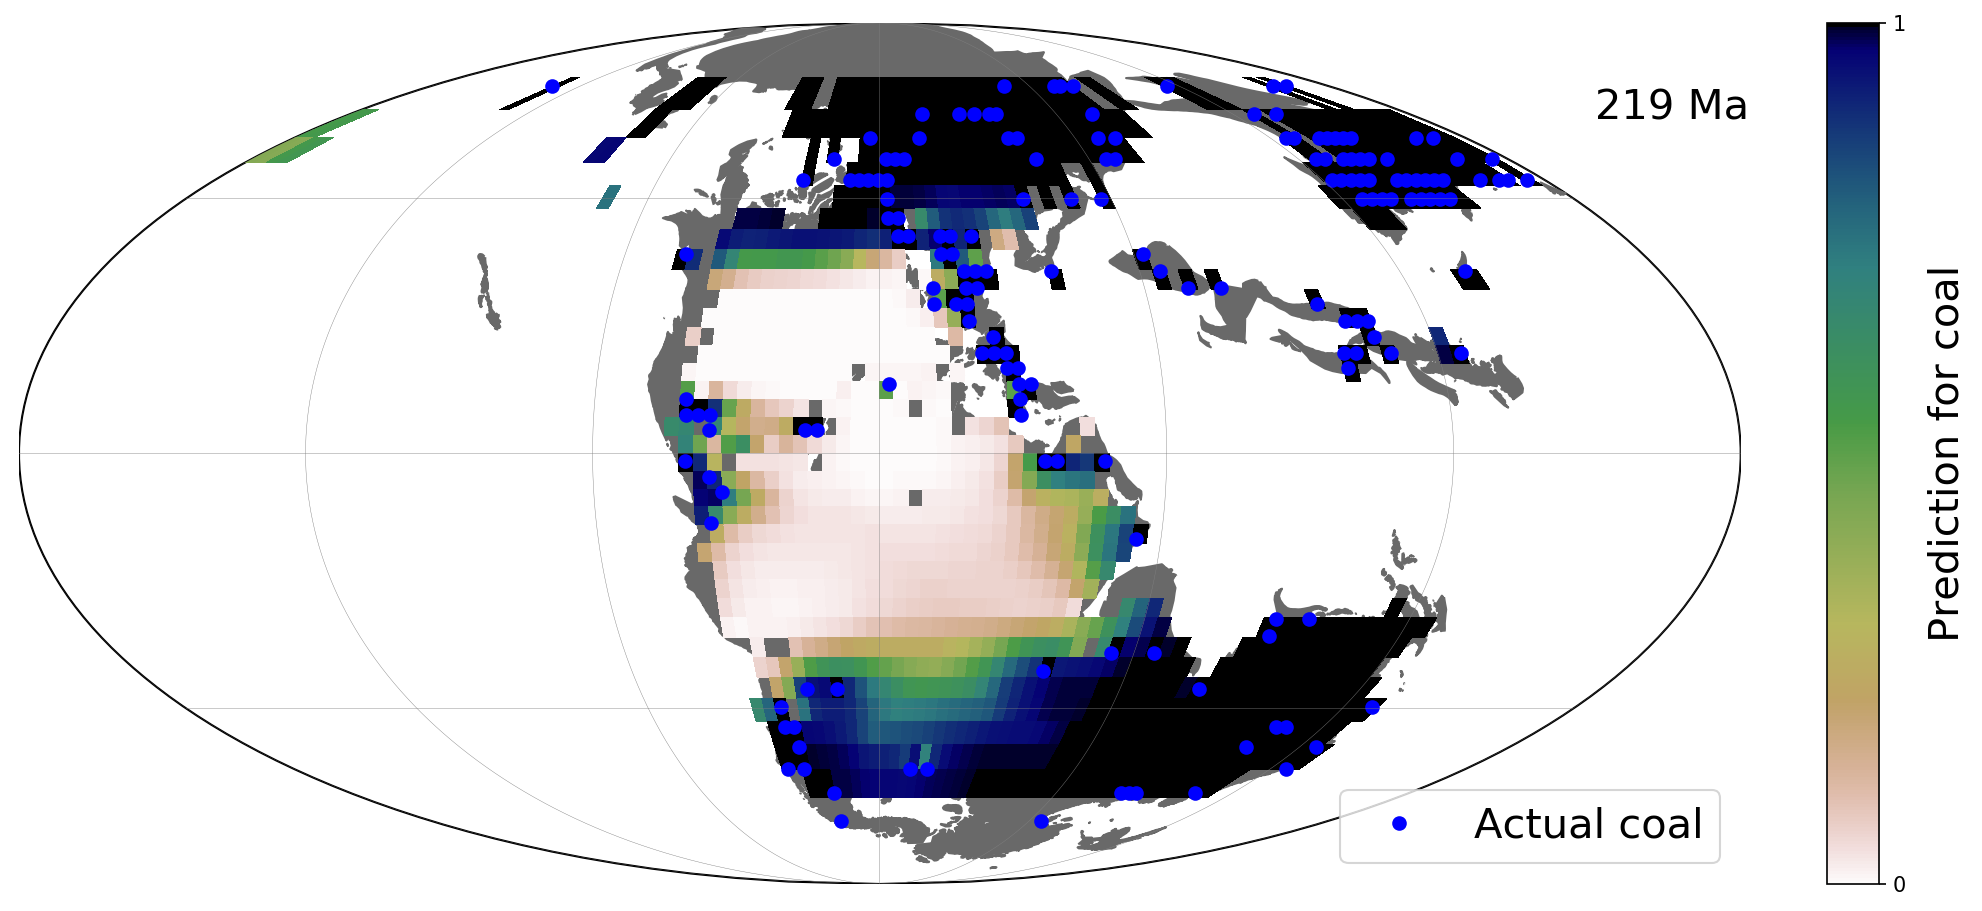

In [127]:
actual_data = predictions[predictions.loc[:,actual_col]>0].loc[:,actual_col].values
actual_lat = predictions[predictions.loc[:,actual_col]>0].loc[:,0].values
actual_lon = predictions[predictions.loc[:,actual_col]>0].loc[:,1].values
map_predict_mean[map_predict_mean==0]=np.nan

fig = plt.figure(figsize=(16,12),dpi=150)
ax = fig.add_subplot(111)

pmap = Basemap(projection='moll', lat_0=0, lon_0=0, resolution='l')
pmap.drawmapboundary(fill_color='white')

#Load in plate polygons for plotting
topologyFile='/Users/nbutter/Projects/GEO/Eocene/paleoclimate-reconstruction/data/PaleomagneticReferenceFrame/reconcoast/reconstructed_'+time1+'.00Ma.shp'
[recs,shapes,fields,Nshp]=readTopologyPlatepolygonFile(topologyFile)
patches   = []
for i, nshp in enumerate(range(Nshp)):
    #These are the plates that cross the dateline and cause 
        #banding errors
        polygonShape=shapes[nshp].points
        poly=np.array(polygonShape)
        testnum=max(poly[:,0])-min(poly[:,0])
        if testnum < 180.0:
            #lon_unwrapped = np.rad2deg(np.unwrap(np.deg2rad(poly[:,0])))
            #print(poly[:,0])
            #print(lon_unwrapped)
            a=pmap(poly[:,0],poly[:,1])
            #a=pmap(lon_unwrapped,poly[:,1])
            b=np.array([a[0],a[1]])
            patches.append(Polygon(b.T,closed=False,color='dimgrey'))
            #pc = PatchCollection(patches, match_original=True, edgecolor='k', linewidths=1., zorder=2)
            #ax.add_collection(pc)
            #xs, ys = pmap(poly[:,0], poly[:,1])
            #pmap.plot(xs, ys, 'k',zorder=1)
        else:
            print(testnum, recs[nshp][8],nshp)
        

pc = PatchCollection(patches, color='dimgrey', linewidths=1, zorder=1)
ax.add_collection(pc)
        
intensity = np.ma.masked_where(np.isnan(map_predict_mean), map_predict_mean)
im1 = pmap.pcolormesh(lons,-lats,intensity,shading='flat',cmap=plt.cm.gist_earth_r,latlon=True)
cb = pmap.colorbar(im1,"right", size="3%", pad="5%",ticks=[0,1],fraction=0.001)
plt.clim(0,1)
cb.set_label('Prediction for '+subject,labelpad=10,size=20)


xh, yh = pmap(actual_lon, actual_lat)
line,=pmap.plot(xh,yh,'ob',label='Actual '+subject)
plt.legend(loc=4,prop={'size': 20})
#pmap.imshow(intensity,extent=[-180,180,-90,90],origin='upper',interpolation='bilinear',cmap=plt.cm.binary)
plt.text(33000000,16000000,time1+" Ma",size=20)


pmap.drawmeridians(np.arange(0, 360, 60),color='grey',dashes=[1,0],linewidth=0.2)
pmap.drawparallels(np.arange(-90, 90, 45),color='grey',dashes=[1,0],linewidth=0.2)



plt.show()

minimum mean prediction is nan
maximum mean prediction is nan


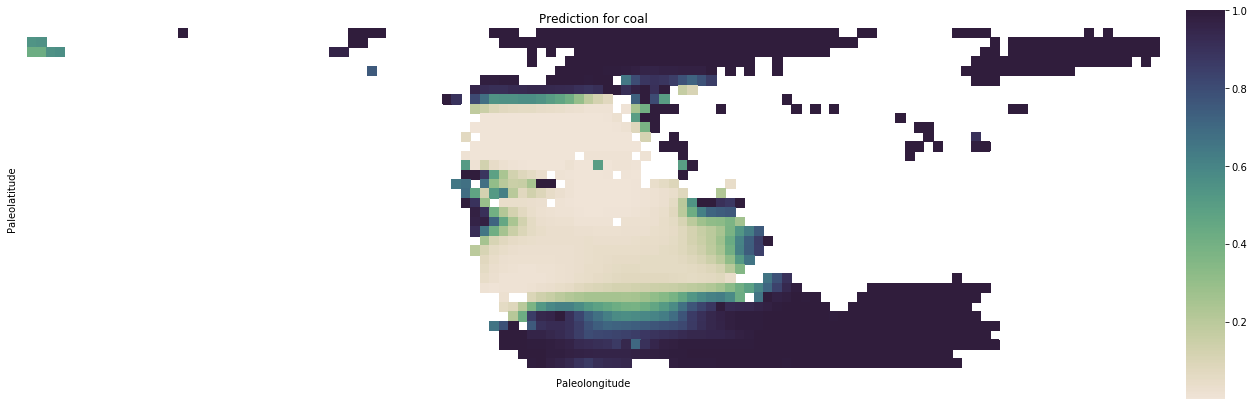

In [128]:
print("minimum mean prediction is "+str(np.ma.array(list(map_predict_mean),mask=mask_exclude).min()))
print("maximum mean prediction is "+str(np.ma.array(list(map_predict_mean),mask=mask_exclude).max()))
fig, ax_prec_pred = plt.subplots(figsize=(18,6))
fig.tight_layout()
fig.subplots_adjust(right=0.9)
cmap = sns.cubehelix_palette(8, start=0.65, rot=-0.9, light=0.9, as_cmap=True)
cbar_ax = fig.add_axes([0.92, 0.05, 0.03, 0.9])
ax_prec_pred.set_title('Prediction for '+subject)
sns.heatmap(map_predict_mean, cmap=cmap, cbar=True,  square=True, xticklabels=False, yticklabels=False, mask=mask_exclude, ax=ax_prec_pred, cbar_ax=cbar_ax)
ax_prec_pred.set_xlabel('Paleolongitude', labelpad=10)
ax_prec_pred.set_ylabel('Paleolatitude',  labelpad=10)

plt.show()

In [138]:
topologyFile='/Users/nbutter/Projects/GEO/Eocene/paleoclimate-reconstruction/data/PaleomagneticReferenceFrame/reconcoast/reconstructed_14.00Ma.shp'
[recs,shapes,fields,Nshp]=readTopologyPlatepolygonFile(topologyFile)
polygonShape=shapes[300].points
poly=np.array(polygonShape)
pos=2
for i in poly:
    if (i[0] >= 0):
        pos=1
    elif (i[0] < 0):
        pos=-1
pol2=poly.sort(axis=0)
print(poly[pol2])
print(poly)

print(np.isnan(map_predict_mean)[:,0])

180.0
180.0
179.8945393172545
179.07992973548716
179.18120201227327
179.57150668750862
180.0
-180.0
-180.0
-179.98482543707146
-179.25712357386178
-178.5069670319634
-177.6635639277088
-177.40241511847043
-177.64910074056604
-178.01331160310912
-179.10257183411468
-180.0
[[[-180.          -43.77186739]
  [-180.          -43.74186061]
  [-180.          -43.56157079]
  [-179.98482544  -43.56110962]
  [-179.25712357  -43.5317324 ]
  [-179.10257183  -43.5317324 ]
  [-178.50696703  -43.5317324 ]
  [-178.0133116   -43.32346282]
  [-177.66356393  -43.32346282]
  [-177.64910074  -43.32346282]
  [-177.40241512  -43.3149667 ]
  [ 179.07992974  -43.27663764]
  [ 179.18120201  -43.08344549]
  [ 179.57150669  -43.06380803]
  [ 179.89453932  -43.01355602]
  [ 180.          -42.95190855]
  [ 180.          -42.8951597 ]
  [ 180.          -42.86171295]]]
[[-180.          -43.77186739]
 [-180.          -43.74186061]
 [-180.          -43.56157079]
 [-179.98482544  -43.56110962]
 [-179.25712357  -43.53173

In [ ]:
polygonShape=shapes[5].points
poly=np.array(polygonShape)
        #lon_unwrapped = np.rad2deg(np.unwrap(np.deg2rad(poly[:,0])))
        #print(poly[:,0])
        #print(lon_unwrapped)
        a=pmap(poly[:,0],poly[:,1])
        #a=pmap(lon_unwrapped,poly[:,1])
        b=np.array([a[0],a[1]])
        patches.append(Polygon(b.T,closed=False,color='dimgrey'))
        #pc = PatchCollection(patches, match_original=True, edgecolor='k', linewidths=1., zorder=2)
        #ax.add_collection(pc)
        #xs, ys = pmap(poly[:,0], poly[:,1])
        #pmap.plot(xs, ys, 'k',zorder=1)

pc = PatchCollection(patches, color='dimgrey', linewidths=1, zorder=1)
ax.add_collection(pc)

In [ ]:
lon_coords = np.arange(-180,180,3)
lat_coords = np.arange(-90,90,3)
lat_spacing=3
lon_spacing=3
nlatbins=len(lat_coords)
nlonbins=len(lon_coords)

len(lon_coords)


lat_spacing

max(lat_coords)


actual_data = predictions[predictions.loc[:,actual_col]>0].loc[:,actual_col].values
actual_lat = predictions[predictions.loc[:,actual_col]>0].loc[:,0].values
actual_lon = predictions[predictions.loc[:,actual_col]>0].loc[:,1].values

actual_data

map_predict_high


nanarr=map_predict_mean
nanarr[nanarr==0]=np.nan
nanarr[np.isfinite(nanarr)]=1
plt.imshow(nanarr)



from netCDF4 import Dataset


plt.pcolormesh(map_predict_mean)


filteredarr=interpolation.spline_filter(map_predict_mean,order=3)
plt.pcolormesh(filteredarr)


filteredarr=filters.gaussian_filter(map_predict_mean,1)
plt.pcolormesh(filteredarr+nanarr)


kernel = np.ones((2,2),np.float32)/4
plt.pcolormesh(cv2.filter2D(map_predict_actual,-1,kernel))


In [ ]:
fig, ax = plt.subplots()
patches=[]
topologyFile='/Users/nbutter/Projects/GEO/Eocene/paleoclimate-reconstruction/data/PaleomagneticReferenceFrame/reconcoast/reconstructed_14.00Ma.shp'
[recs,shapes,fields,Nshp]=readTopologyPlatepolygonFile(topologyFile)
for i, nshp in enumerate(range(Nshp)):
    polygonShape=shapes[nshp].points
    poly=np.array(polygonShape)
    #plt.plot(poly[:,0],poly[:,1])

    patches.append(Polygon(poly,True,fill=True,color='k'))

pc = PatchCollection(patches, match_original=True, edgecolor='k', linewidths=1., zorder=2)
ax.add_collection(pc)

plt.show()
print(poly)
pmap = Basemap(projection='moll', lat_0=0, lon_0=0, resolution='l')
#print(pmap(poly[:,0],poly[:,1]))
a=pmap(poly[:,0],poly[:,1])

Polygon(poly,True,fill=True,color='k')


print(poly.shape)
b=np.array([a[0],a[1]])
print(b.T)

patches.append(Polygon(b.T,closed=False,color='dimgrey'))
        #pc = PatchCollection(patches, match_original=True, edgecolor='k', linewidths=1., zorder=2)
        #ax.add_collection(pc)
        #xs, ys = pmap(poly[:,0], poly[:,1])
        #pmap.plot(xs, ys, 'k',zorder=1)

pc = PatchCollection(patches, color='dimgrey', linewidths=1, zorder=1)
ax.add_collection(pc)


plt.imshow(map_predict_mean)


lon = np.linspace(-80, 80, 25)
lat = np.linspace(30, 70, 25)
lon2d, lat2d = np.meshgrid(lon, lat)
data = np.cos(np.deg2rad(lat2d) * 4) + np.sin(np.deg2rad(lon2d) * 4)


lats[:,0]

In [ ]:
import cartopy.crs as crs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1, 1, 1, projection=crs.Mollweide())
#ax.coastlines()
ax.set_global()
map_predict_mean[map_predict_mean==0]=np.nan
intensity = np.ma.masked_where(np.isnan(map_predict_mean), map_predict_mean)
#ax.imshow(intensity)
#ax.contourf(lons[0,:], lats[:,0], map_predict_mean,transform=crs.PlateCarree())
ax.pcolormesh(lons[0,:], lats[:,0], intensity, cmap=plt.cm.BuGn,transform=crs.PlateCarree())


#im1 = ax.imshow(map_predict_mean, transform=ccrs.PlateCarree(), cmap='BrBG', zorder=0)

topologyFile='/Users/nbutter/Projects/GEO/Eocene/paleoclimate-reconstruction/data/PaleomagneticReferenceFrame/reconcoast/reconstructed_219.00Ma.shp'
import cartopy.io.shapereader as shpreader
adm1_shapes = list(shpreader.Reader(topologyFile).geometries())

ax.add_geometries(adm1_shapes, crs.PlateCarree(),
                  edgecolor='black', facecolor='lightgray')

# [recs,shapes,fields,Nshp]=readTopologyPlatepolygonFile(topologyFile)
# patches   = []
# for i, nshp in enumerate(range(Nshp)):
#     #These are the plates that cross the dateline and cause 
#         #banding errors
#         polygonShape=shapes[nshp].points
#         poly=np.array(polygonShape)
#         #lon_unwrapped = np.rad2deg(np.unwrap(np.deg2rad(poly[:,0])))
#         #print(poly[:,0])
#         #print(lon_unwrapped)
#         #a=pmap(poly[:,0],poly[:,1])
#         #a=pmap(lon_unwrapped,poly[:,1])
#         #b=np.array([a[0],a[1]])
#         #patches.append(Polygon(b.T,closed=True,color='dimgrey'))
#         patches.append(Polygon(poly,closed=False,color='dimgrey'))
#         #pc = PatchCollection(patches, match_original=True, edgecolor='k', linewidths=1., zorder=2)
#         #ax.add_collection(pc)
#         #xs, ys = pmap(poly[:,0], poly[:,1])
#         #pmap.plot(xs, ys, 'k',zorder=1)

pc = PatchCollection(patches, color='dimgrey', linewidths=1, zorder=0,transform=ccrs.PlateCarree())
ax.add_collection(pc)
        
#
#im1 = ax.imshow(intensity,shading='flat',cmap=plt.cm.BuGn,latlon=True)
#im1 = ax.pcolormesh(lons,-lats,intensity) #,shading='flat',cmap=plt.cm.BuGn,latlon=True)
#cb = plt.colorbar(im1,"right", size="3%", pad="5%",ticks=[0,1],fraction=0.001)
#plt.clim(0,1)
#cb.set_label('Prediction for '+subject,labelpad=10)


#xh, yh = pmap(actual_lon, actual_lat)
#line,=ax.plot(xh,yh,'og',label='Actual '+subject)
#plt.legend(loc=4)
#pmap.imshow(intensity,extent=[-180,180,-90,90],origin='upper',interpolation='bilinear',cmap=plt.cm.binary)
#plt.text(33000000,16000000,"14 Ma")


ax.gridlines()
#fig.colorbar(im1, label='km')
#plt.show()